영어 뉴스 데이터 이용

In [ ]:
# 한국어일 때만!

# !pip install konlpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 29.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 465.6/465.6 KB 22.0 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
from gensim.models.word2vec import Word2Vec

from tqdm.notebook import tqdm_notebook
import nltk
from nltk.corpus import stopwords
from sklearn.datasets import fetch_20newsgroups
from tensorflow.keras.preprocessing.text import Tokenizer

nltk는 영어를 불용어할 때 쓰는 라이브러리고, 이는 한국어에도 적용 가능함

In [ ]:
dataset = fetch_20newsgroups(shuffle=True, random_state=1, remove=('headers', 'footers', 'quotes'))
train_data = dataset.data
print('총 샘플 수 :',len(train_data))

총 샘플 수 : 11314


In [ ]:
train_data[:5]

["Well i'm not sure about the story nad it did seem biased. What\nI disagree with is your statement that the U.S. Media is out to\nruin Israels reputation. That is rediculous. The U.S. media is\nthe most pro-israeli media in the world. Having lived in Europe\nI realize that incidences such as the one described in the\nletter have occured. The U.S. media as a whole seem to try to\nignore them. The U.S. is subsidizing Israels existance and the\nEuropeans are not (at least not to the same degree). So I think\nthat might be a reason they report more clearly on the\natrocities.\n\tWhat is a shame is that in Austria, daily reports of\nthe inhuman acts commited by Israeli soldiers and the blessing\nreceived from the Government makes some of the Holocaust guilt\ngo away. After all, look how the Jews are treating other races\nwhen they got power. It is unfortunate.\n",
 "\n\n\n\n\n\n\nYeah, do you expect people to read the FAQ, etc. and actually accept hard\natheism?  No, you need a little leap

In [ ]:
news_df = pd.DataFrame({'document':train_data})

In [ ]:
news_df

document
0      Well i'm not sure about the story nad it did s...
1      \n\n\n\n\n\n\nYeah, do you expect people to re...
2      Although I realize that principle is not one o...
3      Notwithstanding all the legitimate fuss about ...
4      Well, I will have to change the scoring on my ...
...                                                  ...
11309  Danny Rubenstein, an Israeli journalist, will ...
11310                                                 \n
11311  \nI agree.  Home runs off Clemens are always m...
11312  I used HP DeskJet with Orange Micros Grappler ...
11313                                        ^^^^^^\n...

[11314 rows x 1 columns]

In [ ]:
# 특수 문자 제거
news_df['clean_doc'] = news_df['document'].str.replace("[^a-zA-Z]", " ")
# 길이가 3이하인 단어는 제거 (길이가 짧은 단어 제거)
news_df['clean_doc'] = news_df['clean_doc'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))
# 전체 단어에 대한 소문자 변환
news_df['clean_doc'] = news_df['clean_doc'].apply(lambda x: x.lower())

<ipython-input-6-f5d5b90c0f59>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  news_df['clean_doc'] = news_df['document'].str.replace("[^a-zA-Z]", " ")


In [ ]:
news_df

document  \
0      Well i'm not sure about the story nad it did s...   
1      \n\n\n\n\n\n\nYeah, do you expect people to re...   
2      Although I realize that principle is not one o...   
3      Notwithstanding all the legitimate fuss about ...   
4      Well, I will have to change the scoring on my ...   
...                                                  ...   
11309  Danny Rubenstein, an Israeli journalist, will ...   
11310                                                 \n   
11311  \nI agree.  Home runs off Clemens are always m...   
11312  I used HP DeskJet with Orange Micros Grappler ...   
11313                                        ^^^^^^\n...   

                                               clean_doc  
0      well sure about story seem biased what disagre...  
1      yeah expect people read actually accept hard a...  
2      although realize that principle your strongest...  
3      notwithstanding legitimate fuss about this pro...  
4      well will have change scoring playoff pool unf...  
...                                                  ...  
11309  danny rubenstein israeli journalist will speak...  
11310                                                     
11311  agree home runs clemens always memorable kinda...  
11312  used deskjet with orange micros grappler syste...  
11313  argument with murphy scared hell when came las...  

[11314 rows x 2 columns]

In [ ]:
# NULL 값 존재 유무
print(news_df.isnull().values.any())

False


In [ ]:
news_df = news_df.dropna(how = 'any') # Null 값이 존재하는 행 제거
print(news_df.isnull().values.any()) # Null 값이 존재하는지 확인

False


빈 값 유무도 확인해서 빈 값을 Null로 변환하고 제거 진행

In [ ]:
news_df.replace("", float("NaN"), inplace=True)
news_df.isnull().values.any()

True

In [ ]:
news_df.dropna(inplace=True)
print('총 샘플 수 :',len(news_df))

총 샘플 수 : 10995


In [ ]:
!python3 -m nltk.downloader stopwords

/usr/lib/python3.8/runpy.py:127: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# 불용어를 제거
# stop_words = stopwords.words('english')는 nltk에서 지정한 불용어들을 제거하겠다는 것
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

# 불용어 처리를 위해 split 진행 (거의 토크나이징과 유사하게 결과 출력)
tokenized_doc = news_df['clean_doc'].apply(lambda x: x.split())
tokenized_doc = tokenized_doc.apply(lambda x: [item for item in x if item not in stop_words])
tokenized_doc = tokenized_doc.to_list()

In [ ]:
tokenized_doc

[['well',
  'sure',
  'story',
  'seem',
  'biased',
  'disagree',
  'statement',
  'media',
  'ruin',
  'israels',
  'reputation',
  'rediculous',
  'media',
  'israeli',
  'media',
  'world',
  'lived',
  'europe',
  'realize',
  'incidences',
  'described',
  'letter',
  'occured',
  'media',
  'whole',
  'seem',
  'ignore',
  'subsidizing',
  'israels',
  'existance',
  'europeans',
  'least',
  'degree',
  'think',
  'might',
  'reason',
  'report',
  'clearly',
  'atrocities',
  'shame',
  'austria',
  'daily',
  'reports',
  'inhuman',
  'acts',
  'commited',
  'israeli',
  'soldiers',
  'blessing',
  'received',
  'government',
  'makes',
  'holocaust',
  'guilt',
  'away',
  'look',
  'jews',
  'treating',
  'races',
  'power',
  'unfortunate'],
 ['yeah',
  'expect',
  'people',
  'read',
  'actually',
  'accept',
  'hard',
  'atheism',
  'need',
  'little',
  'leap',
  'faith',
  'jimmy',
  'logic',
  'runs',
  'steam',
  'sorry',
  'pity',
  'sorry',
  'feelings',
  'denial'

In [ ]:
# 단어가 1개 이하인 샘플의 인덱스를 찾아서 저장하고, 해당 샘플들은 제거
drop_train = [index for index, sentence in enumerate(tokenized_doc) if len(sentence) <= 1]
tokenized_doc = np.delete(tokenized_doc, drop_train, axis=0)
print('총 샘플 수 :',len(tokenized_doc))

총 샘플 수 : 10940


/usr/local/lib/python3.8/dist-packages/numpy/lib/function_base.py:4454: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asarray(arr)


In [ ]:
tokenized_doc

array([list(['well', 'sure', 'story', 'seem', 'biased', 'disagree', 'statement', 'media', 'ruin', 'israels', 'reputation', 'rediculous', 'media', 'israeli', 'media', 'world', 'lived', 'europe', 'realize', 'incidences', 'described', 'letter', 'occured', 'media', 'whole', 'seem', 'ignore', 'subsidizing', 'israels', 'existance', 'europeans', 'least', 'degree', 'think', 'might', 'reason', 'report', 'clearly', 'atrocities', 'shame', 'austria', 'daily', 'reports', 'inhuman', 'acts', 'commited', 'israeli', 'soldiers', 'blessing', 'received', 'government', 'makes', 'holocaust', 'guilt', 'away', 'look', 'jews', 'treating', 'races', 'power', 'unfortunate']),
       list(['yeah', 'expect', 'people', 'read', 'actually', 'accept', 'hard', 'atheism', 'need', 'little', 'leap', 'faith', 'jimmy', 'logic', 'runs', 'steam', 'sorry', 'pity', 'sorry', 'feelings', 'denial', 'faith', 'need', 'well', 'pretend', 'happily', 'ever', 'anyway', 'maybe', 'start', 'newsgroup', 'atheist', 'hard', 'bummin', 'much', 'f

토크나이징까지 진행한 최종 단어들

In [ ]:
# 위에서 split을 통해 구분했지만, split된 단어들 중 쪼개지는 것이 있을 수 있으니 토크나이징 진행

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(tokenized_doc)

In [ ]:
tokenized_doc

array([list(['well', 'sure', 'story', 'seem', 'biased', 'disagree', 'statement', 'media', 'ruin', 'israels', 'reputation', 'rediculous', 'media', 'israeli', 'media', 'world', 'lived', 'europe', 'realize', 'incidences', 'described', 'letter', 'occured', 'media', 'whole', 'seem', 'ignore', 'subsidizing', 'israels', 'existance', 'europeans', 'least', 'degree', 'think', 'might', 'reason', 'report', 'clearly', 'atrocities', 'shame', 'austria', 'daily', 'reports', 'inhuman', 'acts', 'commited', 'israeli', 'soldiers', 'blessing', 'received', 'government', 'makes', 'holocaust', 'guilt', 'away', 'look', 'jews', 'treating', 'races', 'power', 'unfortunate']),
       list(['yeah', 'expect', 'people', 'read', 'actually', 'accept', 'hard', 'atheism', 'need', 'little', 'leap', 'faith', 'jimmy', 'logic', 'runs', 'steam', 'sorry', 'pity', 'sorry', 'feelings', 'denial', 'faith', 'need', 'well', 'pretend', 'happily', 'ever', 'anyway', 'maybe', 'start', 'newsgroup', 'atheist', 'hard', 'bummin', 'much', 'f

In [ ]:
# 단어 집합의 크기 확인
vocab_size = len(tokenized_doc) + 1 
print('단어 집합의 크기 :', vocab_size)

단어 집합의 크기 : 10941


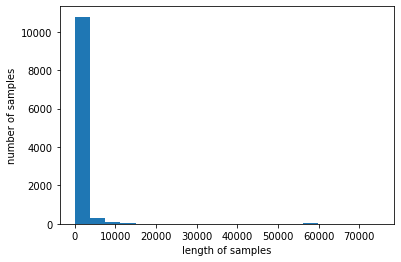

In [ ]:
# 뉴스 데이터 길이 확인
import matplotlib.pyplot as plt

plt.hist([len(s) for s in list(train_data)], bins=20)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

# Word2vec 훈련

size = 워드 벡터의 특징 값. 즉, 임베딩 된 벡터의 차원

window = 컨텍스트 윈도우 크기

negative = 네거티브 샘플링할 때 샘플 개수 지정 (0으로 두면 네거티브 샘플링 X, 네거티브 샘플링 진행 시 보통 5~20으로 지정)

min_count = 단어 최소 빈도 수 제한 (빈도가 적은 단어들은 학습하지 않는다.)

workers = 학습을 위한 프로세스 수

sg = 0은 CBOW, 1은 Skip-gram

In [ ]:
from gensim.models import Word2Vec
model = Word2Vec(sentences = tokenized_doc, size = 100, window = 5, negative = 5, min_count = 5, workers = 4, sg =1)

In [ ]:
# 완성된 임베딩 매트릭스의 크기 확인
model.wv.vectors.shape

(17315, 100)

In [ ]:
print(model.wv.most_similar("articles", topn = 3))

[('references', 0.8864652514457703), ('readers', 0.8621407747268677), ('regularly', 0.8541897535324097), ('faqs', 0.8517171144485474), ('brief', 0.8497516512870789), ('newsgroups', 0.8469647169113159), ('followup', 0.844497799873352), ('newusers', 0.8427152633666992), ('followups', 0.8418655395507812), ('cited', 0.83840012550354)]


In [ ]:
print(model.similarity("articles", "news"))

0.6869607


<ipython-input-32-3a5f0b2fc873>:1: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  print(model.similarity("articles", "news"))


In [ ]:
# negative sampling 설정 전 결과
# print(model.wv.most_similar("article"))

[('news', 0.9812244772911072), ('posted', 0.9563258290290833), ('alastair', 0.945831298828125), ('sent', 0.9389686584472656), ('letter', 0.937227725982666), ('answers', 0.9354908466339111), ('quakers', 0.9344197511672974), ('kkeller', 0.9308046698570251), ('mailing', 0.9273908138275146), ('cathy', 0.9238168001174927)]


In [ ]:
print(model.wv.most_similar("thank"))

[('respond', 0.8461631536483765), ('replies', 0.8428816795349121), ('responded', 0.8385176062583923), ('thanx', 0.835817813873291), ('repost', 0.8279266953468323), ('sincerely', 0.8115257024765015), ('advance', 0.8115236759185791), ('welcome', 0.7998152375221252), ('netters', 0.7993357181549072), ('summarize', 0.7944827675819397)]


In [ ]:
# negative sampling 설정 전 결과
# print(model.wv.most_similar("thank"))

[('respond', 0.9774376153945923), ('post', 0.9579590559005737), ('coupons', 0.9571323394775391), ('reply', 0.9569612741470337), ('zeus', 0.9542564749717712), ('response', 0.9514497518539429), ('give', 0.9478018283843994), ('replies', 0.9471147656440735), ('reading', 0.9466163516044617), ('newsgroup', 0.9454243183135986)]


# 모델 저장

In [ ]:
from gensim.models import KeyedVectors

# The structure is called "KeyedVectors" and is essentially a mapping between *keys*. and *vectors*.

In [ ]:
model.wv.save_word2vec_format('eng_w2v') # 모델 저장
loaded_model = KeyedVectors.load_word2vec_format("eng_w2v") # 모델 로드

In [ ]:
model_result = loaded_model.most_similar("drugs")
print(model_result)

[('hate', 0.9949880838394165), ('harm', 0.9935908317565918), ('disagree', 0.9930051565170288), ('perceive', 0.9910354614257812), ('slightest', 0.9909335970878601), ('justified', 0.9908971786499023), ('necessarily', 0.9908074140548706), ('arrogant', 0.9907286763191223), ('practice', 0.9905096888542175), ('fundamentalists', 0.9901416301727295)]
